# Instituto Superior de Engenharia de Lisboa
## Codificação de Sinais Multimédia
### Trabalho Prático 4

### Docente: 
- Engenheiro Gonçalo Marques

### Trabalho Realizado Por:
- Miguel Silvestre nº45101
- Miguel Távora    nº45102

<hr style="border:2px solid black"> </hr>

## Introdução

O presente trabalho tem como objetivo a implementação dos príncipios base da codificação de vídeo.

Os codificadores atualmente mais utilizadas são o MPEG4 e o H.264.

No trabalho é pretendido implementar três tipos diferentes de codidifcação de vídeo.
As codificações são nomeadamente: codificação intra-frame, inter-frame e inter-frame com compensação de movimento.

Para cada um dos codificadores vão ser utilizadas várias medidas desempenho para testar a qualidade dos codificadores.

<hr style="border:2px solid black"> </hr>

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time

In [2]:
path = "files/"
quality = 50

<hr style="border:2px solid black"> </hr>

## Leitura das imagens originais

In [3]:
def obtain_original_images():
	original_files = []

	for i in range(1, 12):
		path_img = path + "bola_seq/bola_" + str(i) + ".tiff"
		original_files.append(cv2.imread(path_img, cv2.IMREAD_GRAYSCALE))

	return original_files

## Função codificação intra-frame

In [4]:
# intra-frame it's just apply jpeg to all images
def intra_frame_codification(images, quality):
	jpeg_images = []

	# creates the directory if not exists
	directory = path + "intra_frame"
	if not os.path.isdir(directory):
		os.mkdir(directory)

	for index in range(1, len(images) + 1):
		# path to the file, the % is to give 0 before the name
		new_image = directory + "/bola_%02d.jpg" % index

		# writes the image with the quality passed as argument
		cv2.imwrite(new_image, images[index - 1], (cv2.IMWRITE_JPEG_QUALITY, quality))

		jpeg_images.append(cv2.imread(new_image, cv2.IMREAD_GRAYSCALE))

	return jpeg_images

<hr style="border:2px solid black"> </hr>

## Função codificação inter-frame

In [5]:
# inter frame it apply the difference to the PFrame with all others
def inter_frame_codification(images, quality):
	inter_frame_coded = []

	IFrame = images[0]

	# creates the directory if not exists
	directory = path + "coded_inter_frame"
	if not os.path.isdir(directory):
		os.mkdir(directory)

	# writes the Iframe
	cv2.imwrite(directory + "/bola_01.jpg", IFrame, (cv2.IMWRITE_JPEG_QUALITY, quality))

	inter_frame_coded.append(IFrame)

	for i in range(2, len(images) + 1):
		# must be on float64 otherwise gets a noisy image
		IFrame_ref = IFrame.copy().astype(np.float64)

		# PFrame is the difference between current frame and IFrame
		PFrame = (images[i - 1] - IFrame_ref)
		inter_frame_coded.append(PFrame)

		# writes the PFrame on the curresponding directory
		cv2.imwrite(directory + "/bola_%02d.jpg" % i, PFrame, (cv2.IMWRITE_JPEG_QUALITY, quality))

	return inter_frame_coded

## Função descodificação inter-frame

In [6]:
# inter-frame decod is add the difference to the i-frame
def inter_frame_decodification(coded_images, quality):
	decoded_imgs = []

	# obtains the IFrame
	IFrame = coded_images[0]

	# creates the directory if not exists
	directory = path + "decoded_inter_frame"
	if not os.path.isdir(directory):
		os.mkdir(directory)


	# writes the Iframe
	cv2.imwrite(directory + "/bola_01.jpg", IFrame, (cv2.IMWRITE_JPEG_QUALITY, quality))

	for i in range(1, len(coded_images)):
		# obtains the original image
		decoded_img = IFrame + coded_images[i]

		cv2.imwrite(directory + "/bola_%02d.jpg" % (i+1), decoded_img, (cv2.IMWRITE_JPEG_QUALITY, quality))
		decoded_imgs.append(decoded_img)

	return decoded_imgs

<hr style="border:2px solid black"> </hr>

## Função para calcular o Erro Médio Absoluto 

In [7]:
# calculates the absolute mean error
def MAE(block1, block2):
	return np.sum(abs((1.0 * block1) - (1.0 * block2)))

## Função de full-search

In [8]:
# does the full search
def full_search(window_search, block16x16, window_x, window_y, Pframex, Pframey):
	width, height = window_search.shape
	minimum = float('inf')
	line   = 0
	column = 0
	array  = 0

	# -15 to be a window of -15 to +15
	for i in np.arange(width - 15):
		for j in np.arange(height - 15):

			# creates the window search which is 16x16
			block = window_search[i:i + 16, j:j + 16]
			
			# calculate the mean absolute error
			mean_absolute_error = MAE(block16x16, block)

			if mean_absolute_error < minimum:
				# reset the minimum to the mae
				minimum = mean_absolute_error
				# sets the line, column and block where the mean absolute error is the lowest
				line   = i
				column = j
				array  = block


	# coordenates of the lowest MAE on the window search of the image in a window -15, +15
	x = window_x + line
	y = window_y + column

	coordx = x - Pframex
	coordy = y - Pframey

	return array, coordx, coordy

## Função de predição de movimento

In [9]:
# calculates the predicted movement
def movement_predicition(i_frame, p_frame):

	width, height = i_frame.shape
	image = np.zeros((width, height))

	# the size will be the current size of the image divided by 16x16 
	# because it will reduced on vectors
	size = int((width * height) / (16 * 16))
	movement_vector = np.zeros((size, 2))

	index = 0

	# loops over 16 to create a array 16x16
	for line in np.arange(0, width, 16):
		for column in np.arange(0, height, 16):
			# Goes search with a block of 16x16 da P frame, the macroblock locks like i frame
			# the search window is [-15, 15]
			# begin[0] -> xmin, begin[1] -> ymin
			# end[0] -> xmax, end[1] -> ymax
			begin = [line - 15, column - 15]
			end = [(line + 16) + 15, (column + 16) + 15]

			# gets the block 16x16 of the image
			block16x16 = p_frame[line:line + 16, column:column + 16]

			# if it's less than 0 goes 0 to not generate errors
			begin[0] = 0 if begin[0] < 0 else begin[0]
			begin[1] = 0 if begin[1] < 0 else begin[1]
			# if it's bigger than the width or height stays the width or height
			end[0] = width if end[0] > width else end[0]
			end[1] = height if end[1] > height else end[1]

			# obtains the window search to realize the search
			search_window = i_frame[begin[0]:end[0], begin[1]:end[1]]

			block, lin, col = full_search(search_window, block16x16, begin[0], begin[1], line, column)

			# save the movement vector on x and y axis where 
			# the MAE is the lowest which means the macro block is the most alike i-frame
			movement_vector[index] = lin, col
			image[line:line + 16, column:column + 16] = block

			index += 1

	# must add 128 because is better to see the results
	codified = p_frame.astype(np.float64) - image.astype(np.float64) + 128.
	return codified, movement_vector

## Codificação com compensação de movimento

In [10]:
# codification with movement compensation
def codification_compensation_movement(images, quality):

	inter_comp_mov = []
	IFrame = images[0]
	inter_comp_mov.append(IFrame)

	# creates the directory if not exists
	directory = path + "coded_interframe_movement_compensation"
	if not os.path.isdir(directory):
		os.mkdir(directory)

	# writes the Iframe
	cv2.imwrite(directory + "/bola_01.jpg", IFrame, (cv2.IMWRITE_JPEG_QUALITY, quality))

	width, height = IFrame.shape

	# vector where the vectors of the movement compensation will be stored
	vectors = np.zeros((int((width * height) / (16 * 16)), len(images) * 2))

	index = 0

	for i in range(1, len(images)):

		# gets the image codified and the movement vectors
		coded_img, vector = movement_predicition(IFrame, images[i])

		inter_comp_mov.append(coded_img)

		# writes the image
		cv2.imwrite(directory + "/bola_%02d.jpg" % (i + 1), coded_img, (cv2.IMWRITE_JPEG_QUALITY, quality))

		# stores the vector of the coordenates x and y
		vectors[:, index] = vector[:, 0]
		vectors[:, index + 1] = vector[:, 1]
		index += 2

	return inter_comp_mov, vectors

## Descodificação de compensação de movimento

In [11]:
def decod_compensation_movement(images, vectors, quality):

	IFrame = images[0]

	width, height = IFrame.shape

	# creates the directory if not exists
	directory = path + "decoded_interframe_movement_compensation"
	if not os.path.isdir(directory):
		os.mkdir(directory)

	# writes the Iframe
	cv2.imwrite(directory + "/bola_01.jpg", IFrame, (cv2.IMWRITE_JPEG_QUALITY, quality))

	index = 0

	decoded_images = []

	for i in range(1, len(images)):

		vector = vectors[:, index:index + 2]

		index += 2

		new_image = np.zeros((width ,height))
		count = 0

		for line in np.arange(0, width, 16):
			for column in np.arange(0, height, 16):

				# obtains the indexes of the IFrame where get the information to rebuild the image 
				line_size = line + int(vector[count, 0])
				column_size = column+int(vector[count,1])

				# rebuilds the image with the IFrame plus the movement vector
				new_image[line:line + 16, column:column + 16] = IFrame[line_size: line_size+16, column_size: column_size+16]

				count += 1

		# take off the 128 added before
		decoded_image = (new_image.astype(np.float64) + (images[i]).astype(np.float64)) - 128
		decoded_images.append(decoded_image)

		# stores the resulting image
		cv2.imwrite(directory + "/bola_%02d.jpg" %(i + 1), decoded_image, (cv2.IMWRITE_JPEG_QUALITY, quality))

	return decoded_images

<hr style="border:2px solid black"> </hr>

## Função de construção dos vetores de movimento

In [12]:
# shows the movement vectors
def build_movement_vectors(coded_images, vectors):

	# creates the directory if not exists
	directory = path + "coded_interframe_movement_compensation/vectors"
	if not os.path.isdir(directory):
		os.mkdir(directory)

	for index in range(1, len(coded_images)):

		plt.figure(index)

		block_x = coded_images[index].shape[0]/16.
		block_y = coded_images[index].shape[1]/16.

		plt.title("Movement vectors for image " + str("bola_%02d.jpg"%index))

		# coordenates of x and y to the arrows
		X, Y = np.meshgrid(np.arange(0,block_x)*16, np.arange(0,block_y)*16)
		Y[::-1]

		# Give the component x and y to the arrows
		U = ([vector[0] for vector in vectors[:,index-1:index+1]])
		V = [vector[1] for vector in vectors[:,index-1:index+1]]

		plt.quiver(X, Y, U, V, angles = 'xy', scale_units = 'xy' , scale=1)
		plt.gca().invert_yaxis()

		nome_vetores =  directory+ "/vector_%02d"%(index+1) + ".png" 
		plt.savefig(nome_vetores)

<hr style="border:2px solid black"> </hr>

## Função SNR

In [13]:
# calculator of SNR
def snr(img,img2):
	img = img*1.
	img2 = img2*1.
	diff=(img-img2)**2
	diff=np.sum(diff)
	soma=img**2
	soma=np.sum(soma)
	snr=10*np.log10(soma/diff)
	return snr

## Função de taxa de compressão

In [14]:
# measure the compression ratio
def compression_ratio(original_img, compressed_img):
	original_size = os.path.getsize(original_img)
	compressed_size = os.path.getsize(compressed_img)
	return original_size / compressed_size

## Função medição da entropia

In [15]:
# measure the entropy
def measure_entropy(image):
	max_value = 255 # for the uint8 datatype
	prob = np.histogram(image.ravel(), np.arange(0, max_value), density=True)[0]
	return -sum(prob*np.log2(prob+sys.float_info.min))

## Função de medição da energia

In [16]:
# measure the energy
def measure_energy(img):
	img = cv2.imread(img)
	width = img.shape[0]
	height = img.shape[1]
	b, g, r = cv2.split(img)
	sR = [[int(elem) ** 2 for elem in inner] for inner in r]
	sG = [[int(elem) ** 2 for elem in inner] for inner in g]
	sB = [[int(elem) ** 2 for elem in inner] for inner in b]
	energy = (np.sum(sR) + np.sum(sG) + np.sum(sB))*1.0 / (width * height)
	return energy*1.0

<hr style="border:2px solid black"> </hr>

## Função para calcular o SNR, Energia, Taxa compressão da codificação intra-frame

In [17]:
def calculate_variables_intra_frame(original_imgs):

	snrs          = []
	entropys      = []
	compressions  = []
	energys       = []

	for i in range(len(original_imgs)):
		img = cv2.imread(path+"intra_frame/bola_%02d.jpg"%(i+1), cv2.IMREAD_GRAYSCALE)


		snrs.append(snr(original_imgs[i], img))
		entropys.append(measure_entropy(img))
		compressions.append(compression_ratio(path+"bola_seq/bola_"+str(i+1)+".tiff", path+"intra_frame/bola_%02d.jpg"%(i+1)))
		energys.append(measure_energy(path+"intra_frame/bola_%02d.jpg"%(i+1)))

	print("------ Variables for the intra-frame codification -------\n")
	print("SNR:")
	for i in range(len(snrs)):
		print("bola_%02d: "%(i+1), snrs[i])

	print()
	print("Entropy:")
	for i in range(len(entropys)):
		print("bola_%02d: "%(i+1), entropys[i])

	print()
	print("Compression:")
	for i in range(len(entropys)):
		print("bola_%02d: "%(i+1), compressions[i])

	print()
	print("Energy:")
	for i in range(len(entropys)):
		print("bola_%02d: "%(i+1), energys[i])

## Função para calcular o SNR, Energia, Taxa compressão da codificação inter-frame

In [18]:
def calculate_variables_inter_frame(original_imgs):

	snrs          = []
	entropys      = []
	compressions  = []
	energys       = []

	for i in range(len(original_imgs)):
		path_decoded = path+"decoded_inter_frame/bola_%02d.jpg"%(i+1)
		img_decoded = cv2.imread(path_decoded, cv2.IMREAD_GRAYSCALE)
		
		path_coded = path+"coded_inter_frame/bola_%02d.jpg"%(i+1)
		img_coded = cv2.imread(path_coded, cv2.IMREAD_GRAYSCALE)

		snrs.append(snr(original_imgs[i], img_decoded))
		
		entropys.append(measure_entropy(img_coded))
		compressions.append(compression_ratio(path+"bola_seq/bola_"+str(i+1)+".tiff", path_decoded))
		energys.append(measure_energy(path_coded))

	print("------ Variables for the inter-frame codification -------\n")
	print("SNR:")
	for i in range(len(snrs)):
		print("bola_%02d: "%(i+1), snrs[i])

	print()
	print("Entropy:")
	for i in range(len(entropys)):
		print("bola_%02d: "%(i+1), entropys[i])

	print()
	print("Compression:")
	for i in range(len(entropys)):
		print("bola_%02d: "%(i+1), compressions[i])

	print()
	print("Energy:")
	for i in range(len(entropys)):
		print("bola_%02d: "%(i+1), energys[i])

## Função para calcular o SNR... da codificação inter-frame com compensação movimento

In [19]:
def calculate_variables_movement_compensation(original_imgs):

	snrs          = []
	entropys      = []
	compressions  = []
	energys       = []

	for i in range(len(original_imgs)):
		path_decoded = path+"decoded_interframe_movement_compensation/bola_%02d.jpg"%(i+1)
		img = cv2.imread(path_decoded, cv2.IMREAD_GRAYSCALE)
		
		path_coded = path+"coded_interframe_movement_compensation/bola_%02d.jpg"%(i+1)
		img_coded = cv2.imread(path_coded, cv2.IMREAD_GRAYSCALE)

		snrs.append(snr(original_imgs[i], img))
		entropys.append(measure_entropy(img_coded))
		compressions.append(compression_ratio(path+"bola_seq/bola_"+str(i+1)+".tiff", path_decoded))
		energys.append(measure_energy(path_coded))

	print("------ Variables for the inter-frame codification with movement compensation -------")
	print("SNR:")
	for i in range(len(snrs)):
		print("bola_%02d: "%(i+1), snrs[i])

	print()
	print("Entropy:")
	for i in range(len(entropys)):
		print("bola_%02d: "%(i+1), entropys[i])

	print()
	print("Compression:")
	for i in range(len(entropys)):
		print("bola_%02d: "%(i+1), compressions[i])

	print()
	print("Energy:")
	for i in range(len(entropys)):
		print("bola_%02d: "%(i+1), energys[i])

# Função para plot dos gráficos


In [20]:
def graph_plot(path1, path2,path3,path4):
	x=cv2.imread(path1)
	y=cv2.imread(path2)
	z=cv2.imread(path3)
	w=cv2.imread(path4)
	f,axarr=plt.subplots(2,2,figsize=(20, 20), gridspec_kw={'width_ratios': [10, 10], 'height_ratios': [10, 10],'wspace': 0.1, 'hspace': 0.1})
	axarr[0][0].axis('off')
	axarr[0][0].imshow(x)
	axarr[0][1].axis('off')
	axarr[0][1].imshow(y)
	axarr[1][0].axis('off')
	axarr[1][0].imshow(z)
	axarr[1][1].axis('off')
	axarr[1][1].imshow(w)
	plt.show()

<hr style="border:2px solid black"> </hr>

## Execução das funções e tempos de execução

In [21]:
original_files = obtain_original_images()

start_time = time.time()
jpeg_images = intra_frame_codification(original_files, quality)
print("Tempo execução codificação intra-frame")
print("--- %s seconds ---" % (time.time() - start_time)+"\n")


start_time = time.time()
inter_frame_cod = inter_frame_codification(original_files, quality)
inter_frame_decoded = inter_frame_decodification(inter_frame_cod, quality)
print("Tempo execução codificação inter-frame")
print("--- %s seconds ---" % (time.time() - start_time)+"\n")

start_time = time.time()
comp_mov_img, vectors = codification_compensation_movement(original_files, quality)
print("Tempo execução codificação inter-frame com compensação de movimento")
print("--- %s seconds ---" % (time.time() - start_time)+"\n")

start_time = time.time()
decoded_images = decod_compensation_movement(comp_mov_img, vectors, quality)
print("Tempo execução descodificação inter-frame com compensação de movimento")
print("--- %s seconds ---" % (time.time() - start_time))

Tempo execução codificação intra-frame
--- 0.016981840133666992 seconds ---

Tempo execução codificação inter-frame
--- 0.027898550033569336 seconds ---

Tempo execução codificação inter-frame com compensação de movimento
--- 30.785363912582397 seconds ---

Tempo execução descodificação inter-frame com compensação de movimento
--- 0.024955034255981445 seconds ---


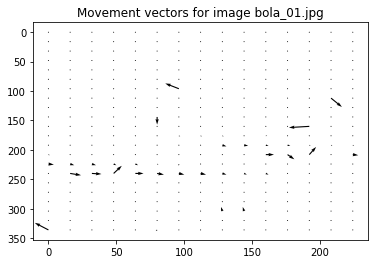

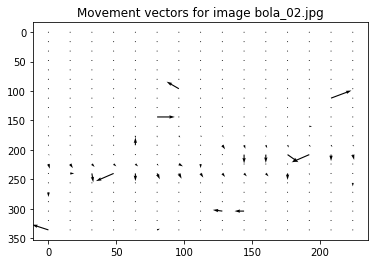

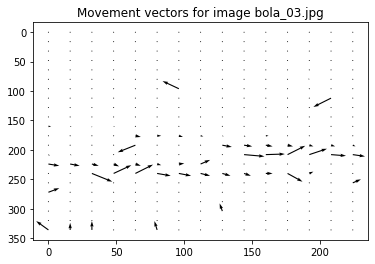

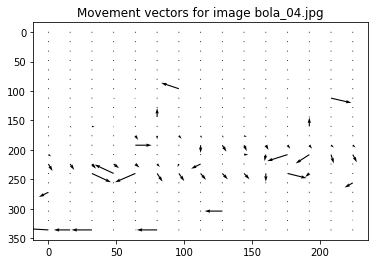

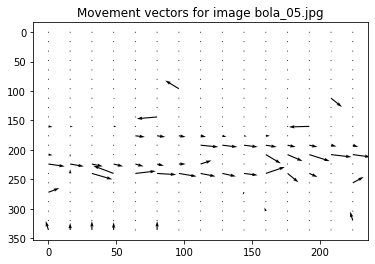

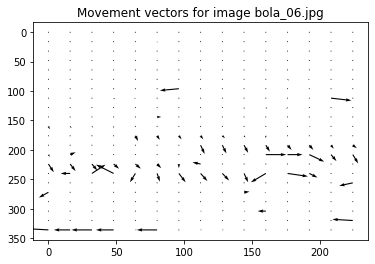

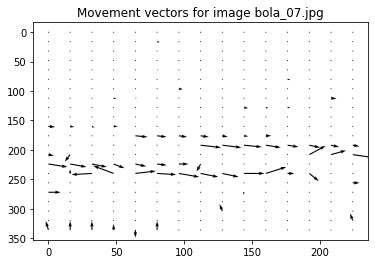

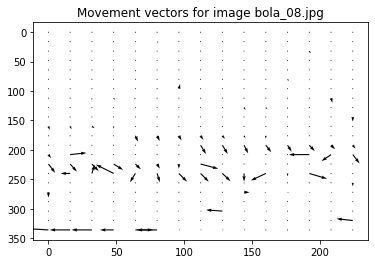

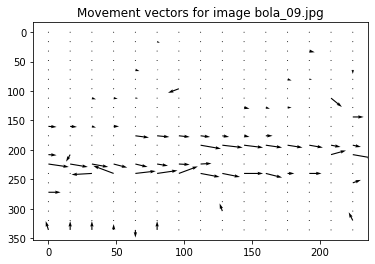

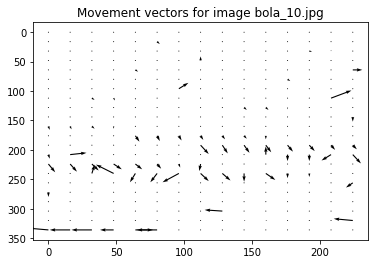

In [22]:
# store the movement vectors
build_movement_vectors(comp_mov_img, vectors)

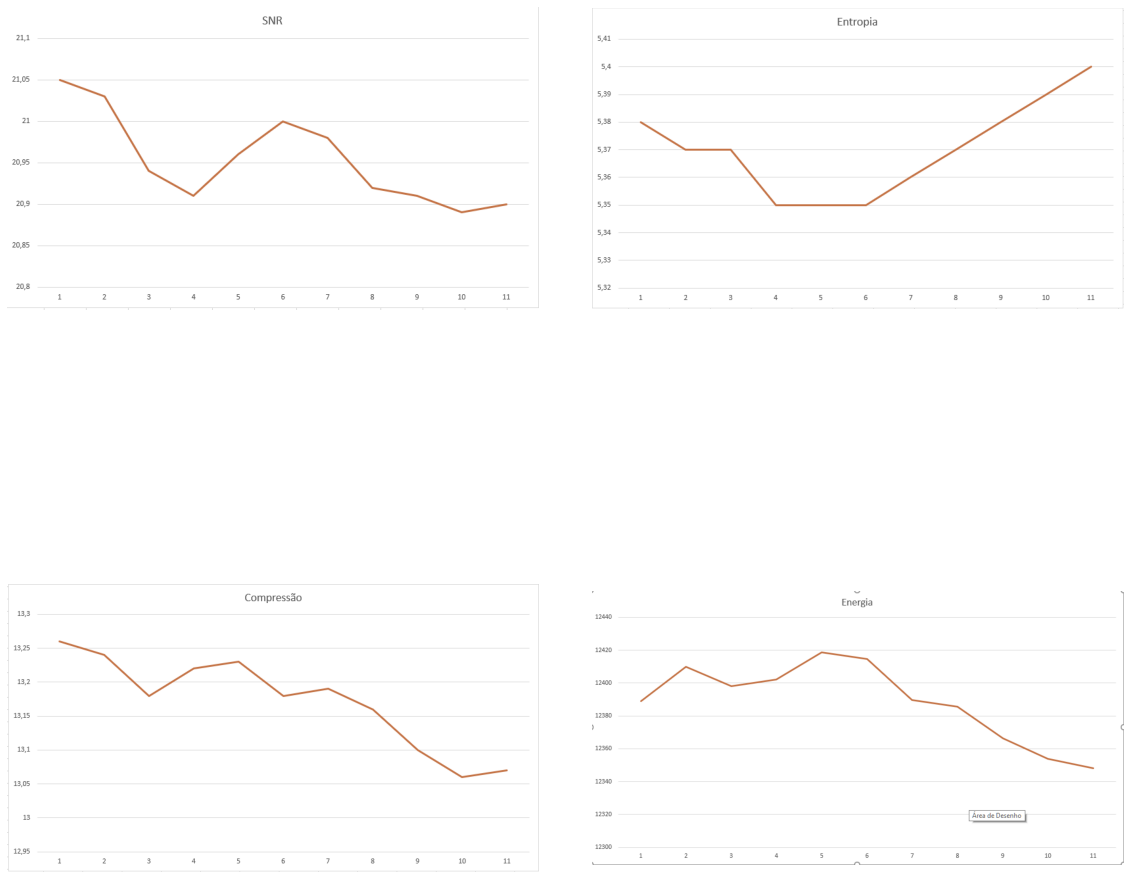

In [23]:
graph_plot("files/Graphics/snr_intraframe.png", "files/Graphics/entropia_intraframe.png",\
          "files/Graphics/compressao_intraframe.png", "files/Graphics/energia_intraframe.png")
# calculate the variables of intra-frame
#calculate_variables_intra_frame(original_files)

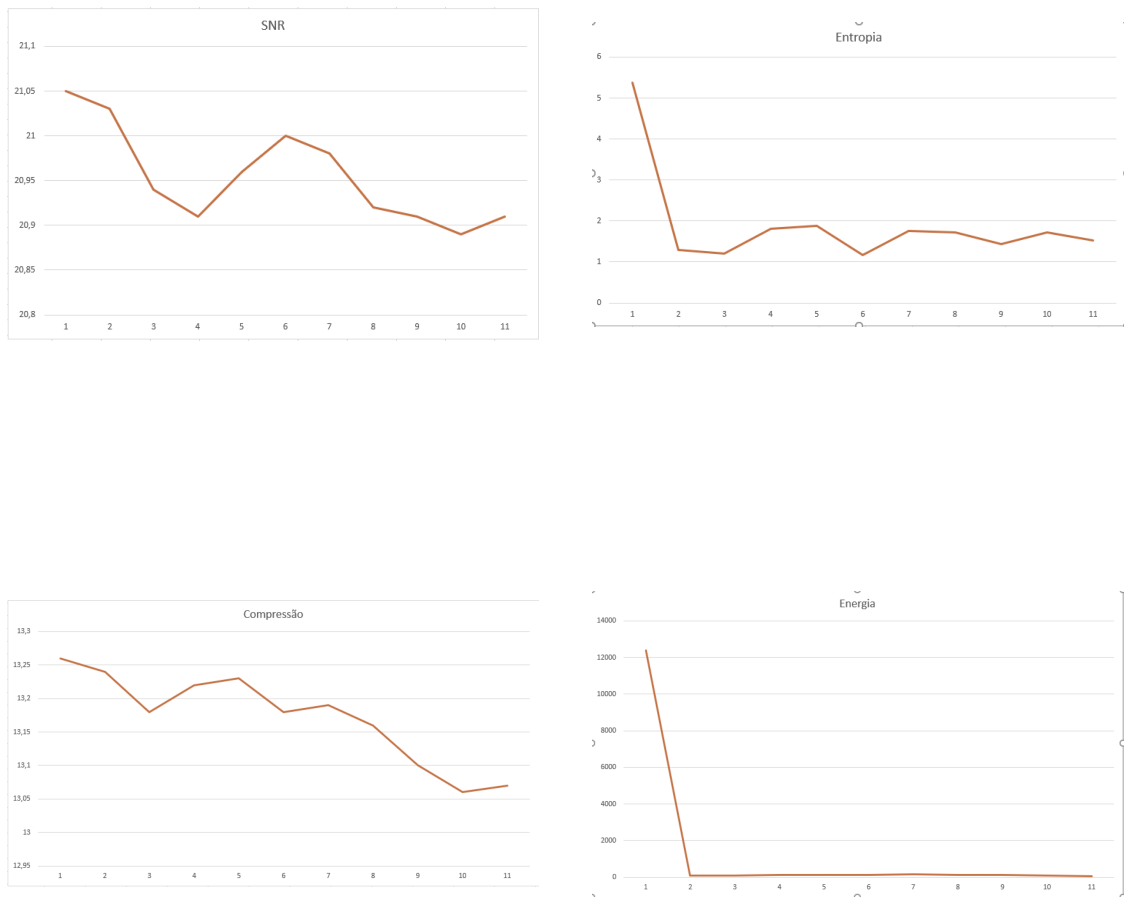

In [24]:
graph_plot("files/Graphics/snr_interframe.png","files/Graphics/entropia_interframe.png",\
           "files/Graphics/compressao_interframe.png","files/Graphics/energia_interframe.png")
# calculate the variables of inter-frame
#calculate_variables_inter_frame(original_files)

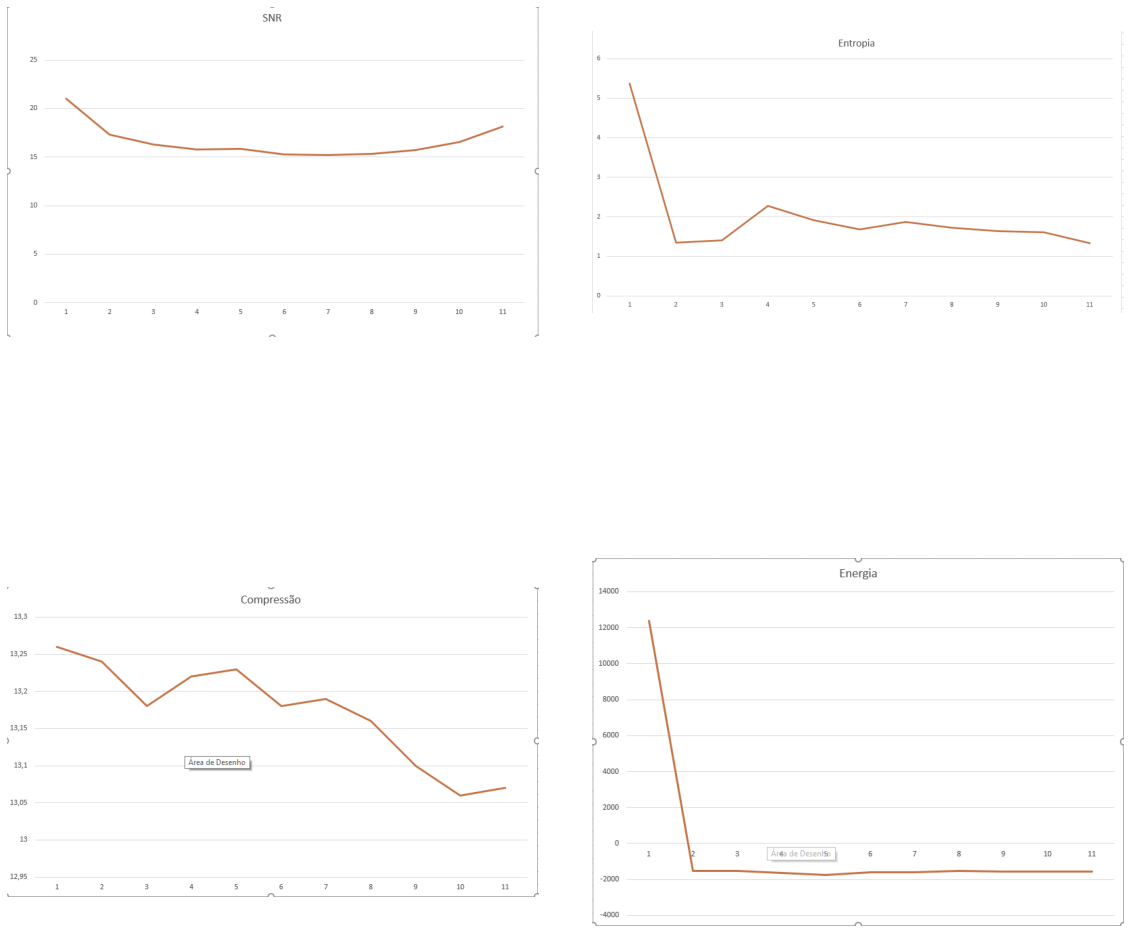

In [25]:
graph_plot("files/Graphics/snr_interframe_compensacao.png","files/Graphics/entropia_interframe_compensacao.png",\
           "files/Graphics/compressao_inter_compensacao.png","files/Graphics/energia_interframe_compensacao.png")
# calculate the variables of movement compensation
#calculate_variables_movement_compensation(original_files)

<hr style="border:2px solid black"> </hr>

# Conclusão

Após concluido o trabalho foram compreendidos os princípios base da codificação de vídeo.

Durante o trabalho foi sentida mais dificuldade na realização da compensação de movimento nomeadamente na construção dos vetores de movimento da imagem.

Perante os resultados em termos do valor do SNR este possui bons resultados, em termos da entropia este também possui resultados aceitáveis visto que não dá valores muito elevados.

Em termos de taxa de compressão este possui resultados bastante bons visto que em todos os casos foi conseguido quase sempre taxas de compressão na ordem dos 13.

Em termos da energia este também parece correto excepto na codificação inter-frame com compensação de movimento que obteve-se energias negativas.